### Edgar Moises Hernandez-Gonzalez
#### 27/02/20-25/03/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### 2 canales C3 y C4
##### Concatenacion vertical
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = 52.08%
##### Kappa = 0.3611

#### CNN-2D BN
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 7000:8000]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 11000:12000]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 7000:8000]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 11000:12000]

In [ ]:
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
x_train = np.concatenate((c3_train, c4_train), axis=1)
x_test = np.concatenate((c3_test, c4_test), axis=1)

In [ ]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 2000)
(288, 2000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#unir 2 canales C3 y C4
def unir_espectrogramas_vertical(data):
  fs = 250
  datos = np.zeros((288,48,4))
  temporal = np.zeros((48,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(2): #2 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    datos[i] = temporal
  return datos

In [ ]:
#llamar a unir_espectrogramas_vertical(data, fs)
x_train = unir_espectrogramas_vertical(x_train)
x_test = unir_espectrogramas_vertical(x_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(288, 48, 4)
(288, 48, 4)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

76.44927548656395
56.146734378722755
1.3045029327757274e-05
3.770593846744206e-06


In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 128.0
x_test /= 128.0

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.59725994
0.43864638
1.0191429e-07
2.9457764e-08


In [ ]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 48, 4, 1)
(288, 48, 4, 1)


In [ ]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(8, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu', padding='same'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
'''def CNN_2D_BN():
  model = Sequential()
  model.add(Conv2D(8, (3,3), padding='same', input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-3)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

Iteration: 1
288/288 - 0s - loss: 1.0519 - acc: 0.4792
kappa:  0.3055555555555556
f1: 0.4762481301631714
confusion matrix:
 [[25 31 11  5]
 [17 41 14  0]
 [ 7  8 31 26]
 [ 8  3 20 41]]


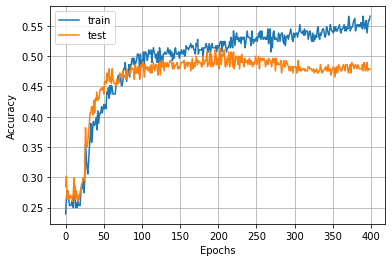

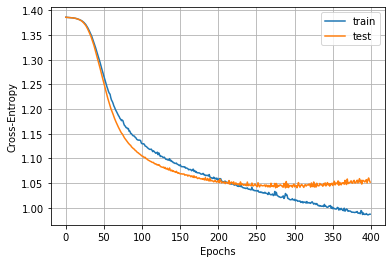

Iteration: 2
288/288 - 0s - loss: 1.0476 - acc: 0.5104
kappa:  0.3472222222222222
f1: 0.508063856259235
confusion matrix:
 [[28 26 13  5]
 [18 41 12  1]
 [ 5  9 34 24]
 [ 6  5 17 44]]


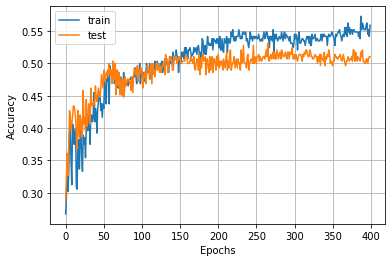

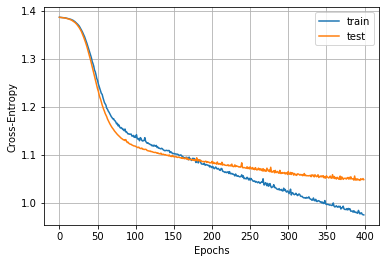

Iteration: 3
288/288 - 0s - loss: 1.0695 - acc: 0.5208
kappa:  0.36111111111111116
f1: 0.519264716207773
confusion matrix:
 [[28 26 14  4]
 [20 38 13  1]
 [ 3  8 39 22]
 [ 4  2 21 45]]


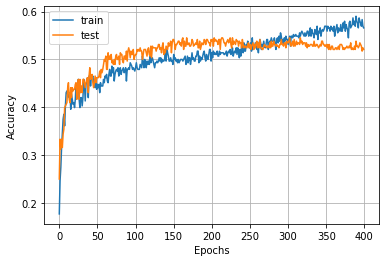

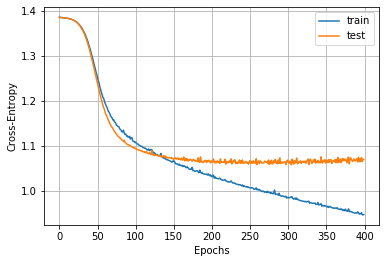

Iteration: 4
288/288 - 0s - loss: 1.0464 - acc: 0.5069
kappa:  0.34259259259259256
f1: 0.5082867210432702
confusion matrix:
 [[30 25 14  3]
 [26 35 10  1]
 [ 7  7 42 16]
 [ 6  1 26 39]]


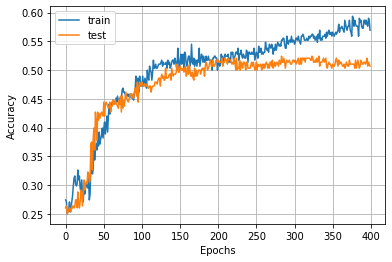

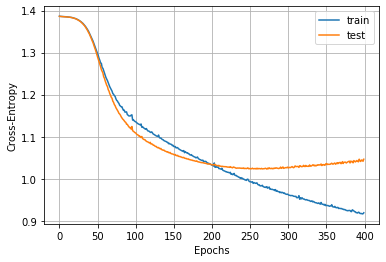

Iteration: 5
288/288 - 0s - loss: 1.0108 - acc: 0.4826
kappa:  0.31018518518518523
f1: 0.47440808960745795
confusion matrix:
 [[23 32 12  5]
 [16 47  9  0]
 [ 3 12 27 30]
 [ 5  2 23 42]]


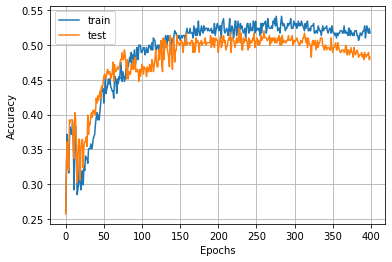

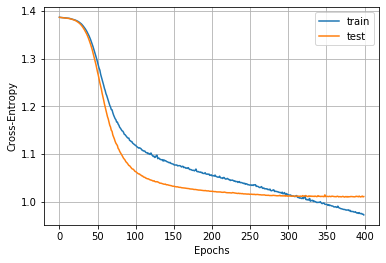


Resultados:
loss: [1.0518860750728183, 1.0476093358463712, 1.069462623861101, 1.0463668637805514, 1.010812951458825]
accuracy: [0.47916666, 0.5104167, 0.5208333, 0.5069444, 0.4826389]
kappa: [0.3055555555555556, 0.3472222222222222, 0.36111111111111116, 0.34259259259259256, 0.31018518518518523]
f1: [0.4762481301631714, 0.508063856259235, 0.519264716207773, 0.5082867210432702, 0.47440808960745795]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 48, 4, 8)          80        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 2, 8)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 2, 8)          584       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 1, 8)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 1, 8)          584       
_________________________________________________________________
flatten_9 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.5000
std: (+/- 0.0163)
Mean Kappa: 0.3333
std: (+/- 0.0217)
Mean F1: 0.4973
Max Accuracy: 0.5208
Max Kappa: 0.3611
Max F1: 0.5193
